In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from utilities import *
from keras import backend as K
from tensorflow.keras import layers, regularizers
import keras
import utils.augmentation as aug

2023-05-02 13:11:21.915955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, dataset,train_set, test_set = load_larger_dataset_first_scenario()

In [31]:
dataset['date'] = dataset['Time'].str.slice(stop=10)
dataset['Day'] = pd.Categorical(dataset.date).codes
dataset

,Time,Action,1,2,3,4,5,6,7,8,...,993,994,995,996,997,998,999,1000,date,Day
0,2020-10-02T13:23:59.000000,go_to_the_bed,-23263.0,-7512.0,11456.0,29950.0,44021.0,55812.0,61418.0,55796.0,...,18862.0,30754.0,32283.0,18984.0,16110.0,18760.0,19438.0,23607.0,2020-10-02,0
1,2020-10-02T13:23:59.000000,go_to_the_bed,-30235.0,-17579.0,-1601.0,15308.0,27720.0,37291.0,43908.0,41487.0,...,8691.0,14573.0,13682.0,3689.0,-849.0,1806.0,4947.0,10792.0,2020-10-02,0
2,2020-10-02T13:24:09.000000,go_to_the_bed,14013.0,15736.0,17230.0,13814.0,6043.0,728.0,548.0,4973.0,...,-7396.0,-20604.0,-29460.0,-34612.0,-30730.0,-21362.0,-10237.0,2890.0,2020-10-02,0
3,2020-10-02T13:24:09.000000,go_to_the_bed,27295.0,34679.0,37292.0,25990.0,10342.0,5157.0,7095.0,12443.0,...,-10743.0,-32674.0,-50402.0,-58257.0,-47608.0,-22649.0,8046.0,38252.0,2020-10-02,0
4,2020-10-02T13:24:29.000000,go_to_the_bed,-5726.0,5323.0,12356.0,17985.0,25981.0,30085.0,32987.0,35940.0,...,36329.0,34953.0,33341.0,29066.0,20560.0,12149.0,5409.0,-2901.0,2020-10-02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16111,2021-02-05T14:02:39.000000,go_to_the_bed,1509.0,-1267.0,2579.0,-767.0,-11999.0,-7665.0,-2095.0,5580.0,...,1344.0,12960.0,12959.0,20902.0,36112.0,56856.0,66613.0,53147.0,2021-02-05,43
16112,2021-02-05T14:02:39.000000,go_to_the_bed,3096.0,-125.0,6540.0,3835.0,-4155.0,-2185.0,-6019.0,4081.0,...,-11550.0,-6682.0,821.0,14051.0,25055.0,44092.0,59292.0,62656.0,2021-02-05,43
16113,2021-02-05T14:02:59.000000,go_to_the_bed,-18235.0,-37640.0,-21082.0,-14378.0,1451.0,13924.0,22153.0,27547.0,...,32135.0,33036.0,31838.0,28856.0,24602.0,20803.0,16821.0,11214.0,2021-02-05,43
16114,2021-02-05T14:02:59.000000,go_to_the_bed,-19415.0,-33202.0,-19889.0,-17692.0,-5022.0,11825.0,23313.0,31354.0,...,28659.0,29733.0,27987.0,25627.0,22036.0,17880.0,13932.0,9292.0,2021-02-05,43


In [23]:
subsets = [train_set[train_set['Action'] == 'go_to_the_bed'],
               train_set[train_set['Action'] == 'sleep_on_stomach'],
               train_set[train_set['Action'] == 'sleep_on_left_side'],
               train_set[train_set['Action'] == 'sleep_on_right_side']]
    
sleep_on_right_side = subsets[3]
sleep_on_right_side

,Time,Action,1,2,3,4,5,6,7,8,...,991,992,993,994,995,996,997,998,999,1000
11,2020-12-02T14:25:59.000000,sleep_on_right_side,44916.0,45921.0,34089.0,36263.0,24319.0,-12639.0,-40948.0,-60553.0,...,-36479.0,-50580.0,-59212.0,-59308.0,-48139.0,-28419.0,1063.0,34526.0,54104.0,63452.0
17,2020-12-11T13:55:29.000000,sleep_on_right_side,55513.0,45383.0,31088.0,30354.0,42870.0,35180.0,23587.0,18313.0,...,30351.0,34194.0,37769.0,40722.0,40234.0,35488.0,28196.0,20532.0,13122.0,7212.0
21,2020-12-07T13:21:39.000000,sleep_on_right_side,3379.0,21457.0,35012.0,41097.0,42971.0,39243.0,28131.0,14099.0,...,-22926.0,8573.0,36288.0,57262.0,51049.0,38968.0,31515.0,21342.0,15188.0,-2428.0
35,2020-12-11T13:14:49.000000,sleep_on_right_side,1774.0,-25244.0,-52264.0,-79135.0,-94057.0,-83154.0,-56625.0,-23379.0,...,2723.0,-739.0,-1191.0,-738.0,-1214.0,9104.0,17490.0,17426.0,11425.0,6172.0
42,2020-12-11T14:22:49.000000,sleep_on_right_side,40181.0,31534.0,27784.0,12113.0,-12647.0,-25980.0,-38964.0,-60585.0,...,-34616.0,-24190.0,-11902.0,610.0,15408.0,28817.0,38445.0,48949.0,57835.0,62385.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11251,2021-01-15T14:21:39.000000,sleep_on_right_side,4715.0,741.0,-4616.0,-4115.0,1887.0,9571.0,18963.0,28105.0,...,72623.0,67260.0,62867.0,48821.0,23663.0,-2183.0,-29460.0,-51050.0,-45787.0,-36208.0
11252,2020-12-07T14:02:19.000000,sleep_on_right_side,51.0,5294.0,13287.0,21719.0,28754.0,36435.0,39914.0,38812.0,...,53393.0,52223.0,49052.0,35284.0,18124.0,3929.0,-4225.0,-7549.0,-9759.0,-8948.0
11256,2021-01-11T14:38:39.000000,sleep_on_right_side,174.0,-10446.0,-21664.0,-15886.0,-9875.0,-1553.0,4679.0,14492.0,...,5655.0,6017.0,5536.0,4716.0,5402.0,7833.0,12041.0,17974.0,24151.0,28885.0
11270,2020-12-08T13:01:49.000000,sleep_on_right_side,-3418.0,-14027.0,-11318.0,-5914.0,1371.0,12692.0,21194.0,26405.0,...,-46138.0,26.0,45671.0,86263.0,110880.0,118872.0,116142.0,100414.0,67583.0,27403.0


In [29]:
subsets = [train_set[train_set['Action'] == 'go_to_the_bed'],
           train_set[train_set['Action'] == 'sleep_on_stomach'],
           train_set[train_set['Action'] == 'sleep_on_left_side'],
           train_set[train_set['Action'] == 'sleep_on_right_side']]

sleep_on_right_side = subsets[3]

sleep_on_right_side_train_x = sleep_on_right_side.iloc[:, 2:]
sleep_on_right_side_train_y = sleep_on_right_side.iloc[:, :2]
sleep_on_right_side_train_x = np.array(sleep_on_right_side_train_x)
x = sleep_on_right_side_train_x.reshape(sleep_on_right_side_train_x.shape[0], sleep_on_right_side_train_x.shape[1], 1)
combined_arr_jittering = np.column_stack((sleep_on_right_side_train_y, np.squeeze(aug.jitter(x))))
tmp1 = pd.DataFrame(combined_arr_jittering, columns=train_set.columns)
tmp = pd.concat([train_set, tmp1], axis=0)

sleep_on_left_side = subsets[2]

sleep_on_left_side_train_x = sleep_on_left_side.iloc[:, 2:]
sleep_on_left_side_train_y = sleep_on_left_side.iloc[:, :2]
sleep_on_left_side_train_x = np.array(sleep_on_left_side_train_x)
x = sleep_on_left_side_train_x.reshape(sleep_on_left_side_train_x.shape[0], sleep_on_left_side_train_x.shape[1], 1)
combined_arr_jittering = np.column_stack((sleep_on_left_side_train_y, np.squeeze(aug.jitter(x))))
jitter = pd.DataFrame(combined_arr_jittering, columns=train_set.columns)
jitter = pd.concat([tmp, jitter], axis=0)
permutation = pd.DataFrame(np.column_stack((sleep_on_left_side_train_y,np.squeeze(aug.permutation(x)))), columns=train_set.columns)
permutation = pd.concat([jitter, permutation], axis=0)
window_warp = pd.DataFrame(np.column_stack((sleep_on_left_side_train_y,np.squeeze(aug.window_warp(x)))),columns=train_set.columns)
tmp = pd.concat([permutation, window_warp], axis=0)


sleep_on_stomach = subsets[1]

sleep_on_stomach_train_x = sleep_on_stomach.iloc[:, 2:]
sleep_on_stomach_train_y = sleep_on_stomach.iloc[:, :2]
sleep_on_stomach_train_x = np.array(sleep_on_stomach_train_x)
x = sleep_on_stomach_train_x.reshape(sleep_on_stomach_train_x.shape[0], sleep_on_stomach_train_x.shape[1], 1)
combined_arr_jittering = np.column_stack((sleep_on_stomach_train_y, np.squeeze(aug.jitter(x))))
jitter = pd.DataFrame(combined_arr_jittering, columns=train_set.columns)
jitter = pd.concat([tmp, jitter], axis=0)
permutation = pd.DataFrame(np.column_stack((sleep_on_stomach_train_y,np.squeeze(aug.permutation(x)))), columns=train_set.columns)
permutation = pd.concat([jitter, permutation], axis=0)
window_warp = pd.DataFrame(np.column_stack((sleep_on_stomach_train_y,np.squeeze(aug.window_warp(x)))),columns=train_set.columns)
tmp = pd.concat([permutation, window_warp], axis=0)
tmp


,Time,Action,1,2,3,4,5,6,7,8,...,991,992,993,994,995,996,997,998,999,1000
0,2020-12-09T14:41:39.000000,go_to_the_bed,57415.0,63829.0,66366.0,53003.0,13450.0,-48441.0,-89877.0,-93858.0,...,79136.0,47330.0,15744.0,-11459.0,-33202.0,-49646.0,-53965.0,-37542.0,-19694.0,-2299.0
1,2020-10-10T13:37:49.000000,go_to_the_bed,-1093.0,-1112.0,-4635.0,-10290.0,-6219.0,-2004.0,-7239.0,-7738.0,...,-13428.0,-14658.0,-6520.0,-3601.0,-5245.0,892.0,6364.0,5814.0,12697.0,24600.0
2,2020-11-12T14:22:49.000000,go_to_the_bed,25095.0,23130.0,20468.0,18593.0,16950.0,14597.0,12370.0,10271.0,...,4038.0,3425.0,4169.0,7257.0,11734.0,16728.0,21140.0,22810.0,26596.0,27809.0
3,2020-10-26T13:55:39.000000,go_to_the_bed,56682.0,50618.0,41165.0,31735.0,23432.0,14495.0,7164.0,924.0,...,-10108.0,-16498.0,-23037.0,-28061.0,-30672.0,-33585.0,-33094.0,-22912.0,-5364.0,10842.0
4,2020-12-09T15:16:39.000000,sleep_on_left_side,-14025.0,1782.0,19911.0,37748.0,51605.0,62335.0,68313.0,69307.0,...,6896.0,17696.0,28094.0,37108.0,41240.0,42235.0,43328.0,44129.0,41693.0,35735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,2020-11-24T13:24:49.000000,sleep_on_stomach,11021.0,1062.674675,-3264.077077,-3425.246246,-5770.401401,-4142.992993,4443.633634,16719.944945,...,29150.198198,17884.646647,8804.488488,2231.42042,-4747.184184,-7835.191191,-1035.279279,11278.359359,22395.694695,35581.0
1404,2021-01-20T14:29:59.000000,sleep_on_stomach,-6271.0,20189.855856,56373.23023,76549.918919,75611.156156,62460.32032,44424.693694,24869.563564,...,6011.945946,19533.413413,31835.795796,42080.864865,47857.783784,46888.92993,41301.537538,32779.406406,22530.982983,14616.0
1405,2021-01-20T14:18:09.000000,sleep_on_stomach,1544.0,-7496.673674,-1667.401401,15963.009009,34937.199199,50706.821822,60408.222222,63101.034034,...,18680.954955,9682.058058,1163.634635,-5147.261261,-9088.036036,-9900.406406,-5784.804805,485.920921,9270.505506,18865.0
1406,2020-12-09T14:30:59.000000,sleep_on_stomach,11466.0,23014.915916,5038.066066,-28033.663664,-64750.171171,-86063.584585,-75535.096096,-54147.356356,...,-2840.720721,13078.523524,36358.970971,59570.249249,74949.562563,81204.985986,71785.663664,52116.980981,41936.811812,23257.0


In [4]:
pd.DataFrame(train_set_y_orig.value_counts())

,count
Action,
go_to_the_bed,5896
sleep_on_right_side,2526
sleep_on_left_side,1451
sleep_on_stomach,1408


In [5]:
pd.DataFrame(test_set_y_orig.value_counts())

,count
Action,
go_to_the_bed,3079
sleep_on_left_side,1120
sleep_on_stomach,474
sleep_on_right_side,162


In [6]:
train_set_y = transform_label(train_set_y_orig)
test_set_y = transform_label(test_set_y_orig)

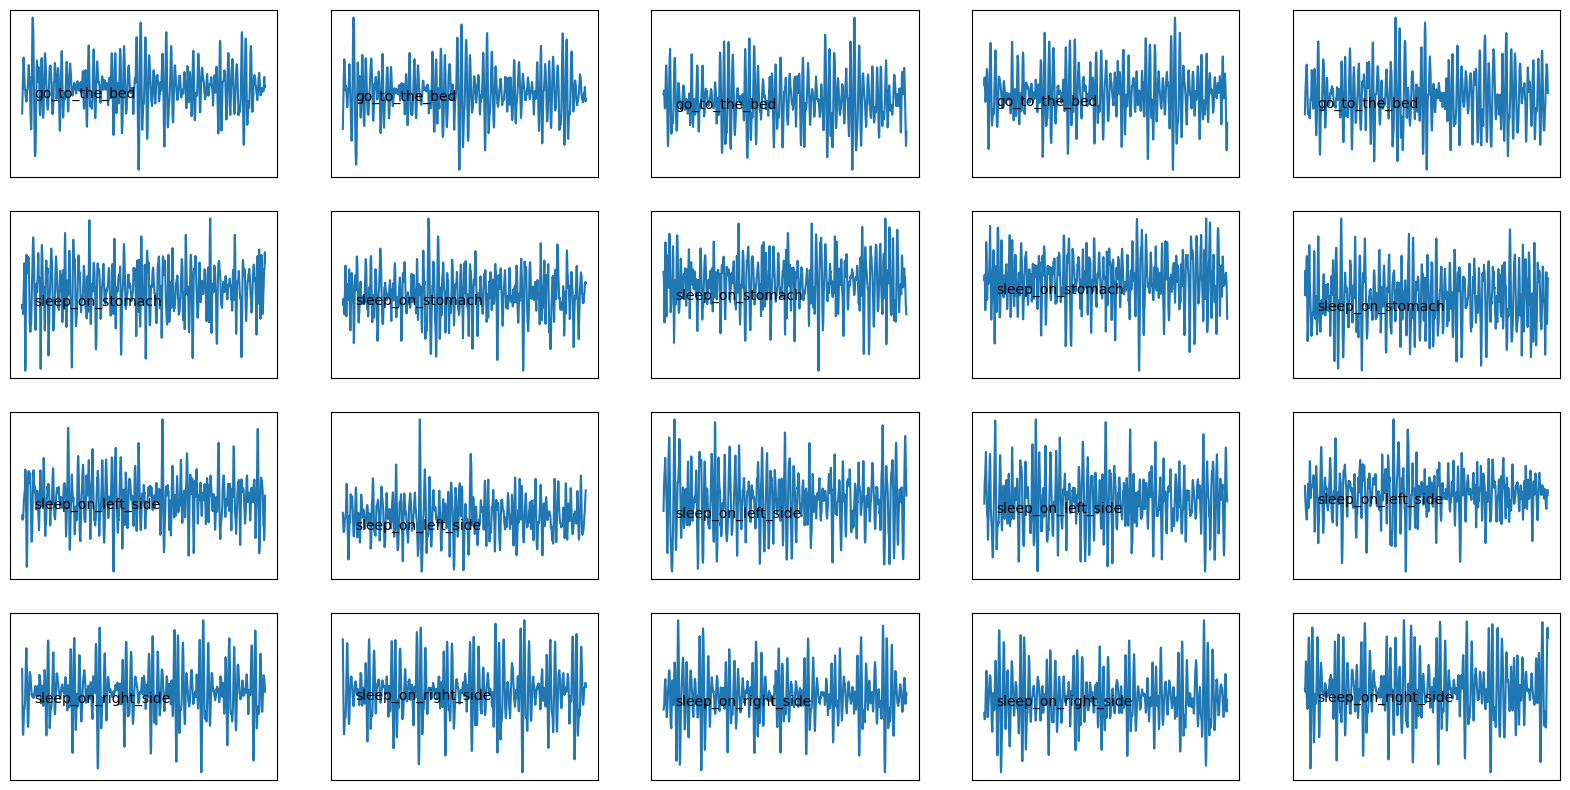

In [7]:
mode_showing(5)

In [8]:
Y = pd.get_dummies(train_set_y)
Y = Y.replace({True: 1, False: 0}).astype(float)

from sklearn.preprocessing import StandardScaler

# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler to your dataframe and transform it
train_x_std = scaler.fit_transform(train_set_x_orig)
train_x = pd.DataFrame(train_x_std)

In [14]:
def create_first_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(1000), # dimension of X matrix
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10000, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(5000, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1000, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(200, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(20, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['acc'])
    return model

In [15]:
import keras
first_model = create_first_model()
callbacks=[
           keras.callbacks.EarlyStopping(monitor='loss',
           patience=5,
           ),
           keras.callbacks.TensorBoard(
               log_dir='my_log_dir',
               histogram_freq=1,
               embeddings_freq=1,
           )
]

first_history = first_model.fit(
    train_x.values,
    Y.values,
    validation_split=0.3,
    epochs=100,
    # callbacks=callbacks,
    batch_size=100,
    callbacks=[callbacks],
);

Epoch 1/100
79/79 [==============================] - 63s 784ms/step - loss: 52.1690 - acc: 0.3508 - val_loss: 12.2607 - val_acc: 0.5019
Epoch 2/100
79/79 [==============================] - 64s 815ms/step - loss: 6.6477 - acc: 0.4457 - val_loss: 3.7693 - val_acc: 0.5123
Epoch 3/100
79/79 [==============================] - 64s 809ms/step - loss: 3.1242 - acc: 0.4676 - val_loss: 2.6620 - val_acc: 0.5099
Epoch 4/100
79/79 [==============================] - 66s 843ms/step - loss: 2.4936 - acc: 0.4961 - val_loss: 2.3431 - val_acc: 0.5155
Epoch 5/100
79/79 [==============================] - 62s 794ms/step - loss: 2.2760 - acc: 0.5016 - val_loss: 2.1438 - val_acc: 0.5158
Epoch 6/100
79/79 [==============================] - 66s 838ms/step - loss: 2.1115 - acc: 0.5062 - val_loss: 2.0484 - val_acc: 0.5161
Epoch 7/100
79/79 [==============================] - 64s 818ms/step - loss: 2.0467 - acc: 0.5133 - val_loss: 2.0105 - val_acc: 0.5161
Epoch 8/100
79/79 [==============================] - 63s 801

In [16]:
scaler = StandardScaler()
# fit the scaler to your dataframe and transform it
test_x_std = scaler.fit_transform(test_set_x_orig)
test_x = pd.DataFrame(test_x_std)

result = first_model.predict(test_x)
tmp = np.argmax(result, axis=1)

from sklearn.metrics import accuracy_score
print(accuracy_score(test_set_y,tmp))


152/152 [==============================] - 7s 39ms/step
0.6368148914167528


In [18]:
from sklearn.metrics import confusion_matrix
NN_confusion_matrix = confusion_matrix(test_set_y, tmp).T
print(NN_confusion_matrix)

[[3079  474 1120  162]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]
